In [45]:
from collections.abc import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


In [8]:
def ensure_iris_df(df: pd.DataFrame | None=None) -> pd.DataFrame:
    needed = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
    if df is None or not set(needed).issubset(df.columns):
        data = load_iris()
        df = pd.DataFrame(
            data=data.data,
            columns=['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
        )
        df['class'] = data.target
    return df[needed].copy()

In [17]:

def elbow_inertia(X: np.ndarray, k_range: Iterable[int], random_state: int=42) -> list[float]:
    inertias: list[float] = []
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
        model.fit(X)
        inertias.append(model.inertia_)
    return inertias

In [9]:
df = ensure_iris_df()
feature_cols = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
X = df[feature_cols].values
y_true = df['class'].values

In [27]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
k_range_elbow = range(1, 11)
k_range_sil = range(2, 11)

In [29]:
inertias = elbow_inertia(X_scaled, k_range_elbow)

In [30]:
inertias

[250.06200865345477,
 114.80605147182254,
 73.19198434012038,
 64.86980074450312,
 48.787964656021074,
 39.173478539681746,
 36.183057100388105,
 29.977894977561736,
 27.015159438577612,
 22.306454625735014]

In [31]:
from collections.abc import Sequence


def plot_elbow(k_values: Sequence[int],inertias: Sequence[float], title: str='Elbow method for optional k' ) -> None:
    if len(k_values) != len(inertias):
        raise ValueError('k_values and inertias must have the same length.')

    fig, ax = plt.subplots(figsize=(12, 8), dpi=120)

    ax.plot(
        k_values,
        inertias,
        marker='o',
        color='tab:blue',
        linewidth=2,
        markersize=8
    )

    for k, inertia in zip(k_values, inertias):
        ax.annotate(
            text=f'{k}',
            xy=(k, inertia),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            color='white',
            ha='left',
            va='bottom',
            alpha=0.8
        )

    ax.set_title('title')
    ax.set_xlabel('k')
    ax.set_ylabel('inertia')

    ax.grid(True)

    plt.tight_layout()
    plt.show()

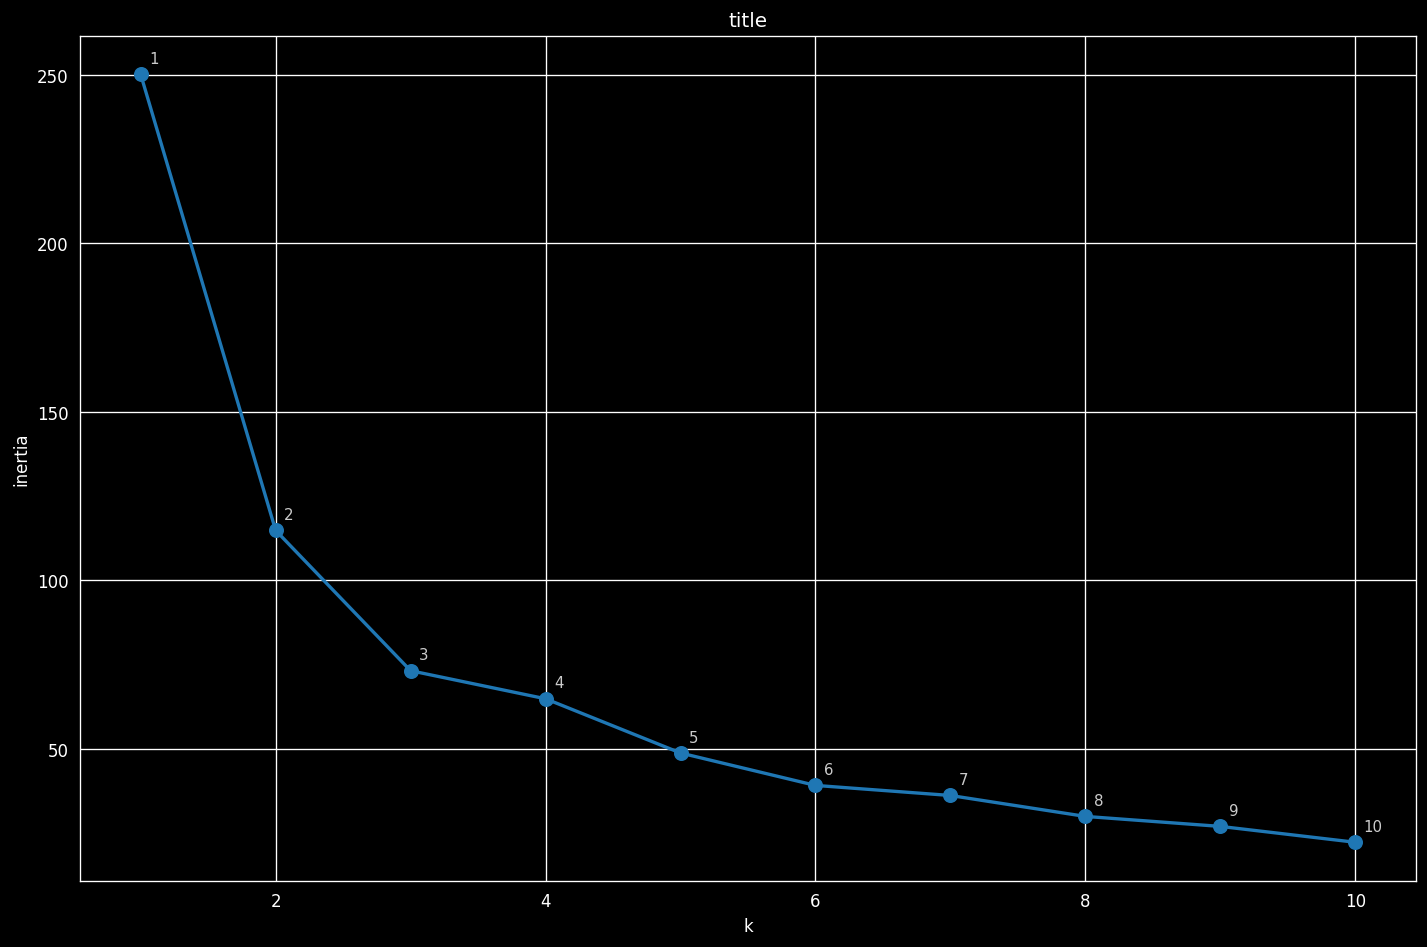

In [32]:
plot_elbow(k_range_elbow, inertias)

In [33]:


def plot_elbow_curve_with_annotation(
    k_values: Sequence[int],
    inertias: Sequence[float],
    title: str = "Elbow Method for Optimal k",
    figsize: tuple[int, int] = (8, 6),
    dpi: int = 120,
    color_line: str = "tab:blue",
    color_elbow: str = "tab:red",
    annotate_elbow: bool = True,
) -> int:
    """
    Plot an Elbow Curve for K-Means and (optionally) mark the detected 'elbow'.

    Parameters
    ----------
    k_values : Sequence[int]
        Range of k values tested.
    inertias : Sequence[float]
        Corresponding inertia (WSS) for each k.
    title : str, optional
        Title of the plot.
    figsize : tuple[int, int], optional
        Figure size in inches.
    dpi : int, optional
        Resolution of the figure.
    color_line : str, optional
        Color of the main line.
    color_elbow : str, optional
        Color used to highlight the detected elbow point.
    annotate_elbow : bool, optional
        Whether to display an annotation arrow for the elbow.

    Returns
    -------
    int
        The detected optimal number of clusters (elbow point).
    """
    if len(k_values) != len(inertias):
        raise ValueError("`k_values` and `inertias` must have the same length.")

    ks = np.array(list(k_values), dtype=float)
    ys = np.array(inertias, dtype=float)


    x1, y1 = ks[0], ys[0]
    x2, y2 = ks[-1], ys[-1]
    num = np.abs((y2 - y1) * ks - (x2 - x1) * ys + (x2 * y1 - y2 * x1))
    den = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
    distances = num / den
    elbow_idx = int(np.argmax(distances))
    elbow_k = int(ks[elbow_idx])


    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(ks, ys, marker="o", color=color_line, linewidth=2, markersize=7)
    plt.title(title, fontsize=14, weight="bold")
    plt.xlabel("Number of Clusters (k)", fontsize=12)
    plt.ylabel("Inertia (Within-cluster sum of squares)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)


    if annotate_elbow:
        plt.scatter(ks[elbow_idx], ys[elbow_idx], color=color_elbow, s=120, zorder=5)
        plt.annotate(
            text=f"Elbow at k={elbow_k}",
            xy=(ks[elbow_idx], ys[elbow_idx]),
            xytext=(20, 20),
            textcoords="offset points",
            fontsize=10,
            color=color_elbow,
            fontweight="bold",
            arrowprops=dict(
                arrowstyle="->",
                color=color_elbow,
                lw=1.5,
                shrinkA=0,
                shrinkB=5,
            ),
        )

    plt.tight_layout()
    plt.show()

    return elbow_k



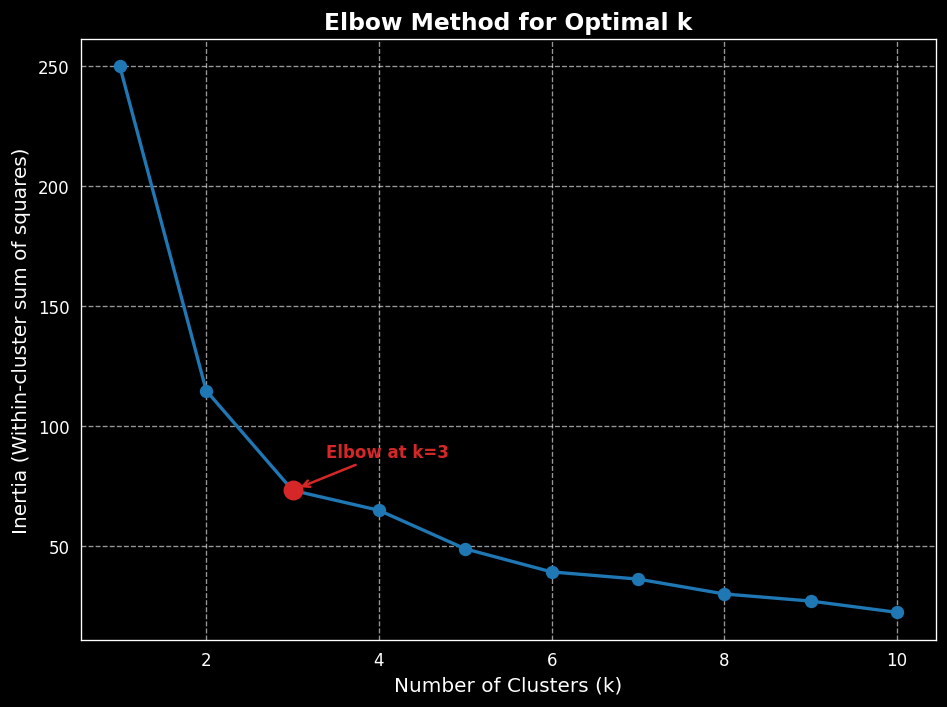

3

In [34]:
plot_elbow_curve_with_annotation(k_range_elbow, inertias)

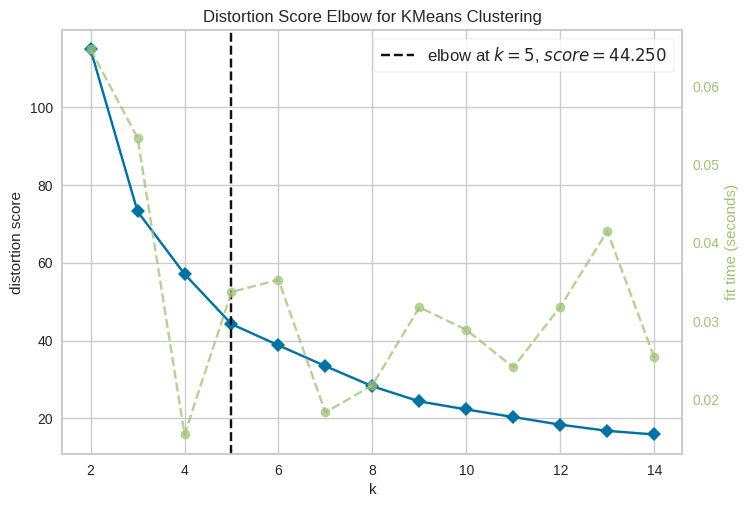

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
model_yellow = KMeans(n_clusters=3, random_state=42, n_init=10)
visualizer = KElbowVisualizer(model_yellow, k=(2, 15), metric='distortion', force_model=True)
visualizer.fit(X_scaled)
visualizer.show()